# Credit Card Default Prediction
Course Project of ISOM 3360, Spring 2020 

Group 21

In [1]:
# Import basic libraries
import numpy as np 
import pandas as pd
import joblib # for saving models

In [2]:
# Load local data
data = pd.read_csv('data/data.csv',index_col = 'ID')


## Variables


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [6]:
data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## Data Cleaning
<b>Variable name:

PAY_0 is very confusing, should be changed to PAY_1 in consistensy with other variable names.Change target variable name from 'default.pay.next.month' to 'def_pay'</b>

In [10]:
# Change variable name
data = data.rename(columns={'default.payment.next.month': 'def_pay', 'PAY_0': 'PAY_1'})

In [11]:
# To have a general idea of the default probability
data['def_pay'].value_counts()[1] / data.shape[0]

0.2212

<b>Conclusion: The dataset has a mild degree of imbalance, which is not considered as a significant problem.</b>

In [12]:
# Categorical variables
data['SEX'].value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [13]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

<b>EDUCATION has category 5 and 6 which are 'unknown', and label 0 which is undocumented. They can all be considered as missing values.</b>

In [14]:
# Missing values are filled with random value according to probability of occurrence
mask_edu_good=data['EDUCATION'].isin(range(1,5))
data['EDUCATION'].mask(~mask_edu_good,data['EDUCATION'][mask_edu_good].sample(n=(~mask_edu_good).sum(),replace=True).tolist(),inplace=True)
data['EDUCATION'].value_counts()

2    14188
1    10713
3     4974
4      125
Name: EDUCATION, dtype: int64

In [15]:
data['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

<b>MARRIAGE has a label 0 that is undocumented. It can be considered as missing value.</b>

In [16]:
mask_marriage_good=data['MARRIAGE'].isin(range(1,4))
data['MARRIAGE'].mask(~mask_marriage_good,data['MARRIAGE'][mask_marriage_good].sample(n=(~mask_marriage_good).sum(),replace=True).tolist(),inplace=True)
data['MARRIAGE'].value_counts()

2    15992
1    13685
3      323
Name: MARRIAGE, dtype: int64

 <b>One might wonder what these labels might mean something.

"Other" in education can be education lower than the high school level.

"Other" in marriage could be, for example, "divorced". </b>


In [17]:
# Create lists for relevant numerical features
repayments = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amounts = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [18]:
# final check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

In [19]:
# export to csv
data.to_csv('data/data_clean.csv')

## Data visualization

In [58]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [59]:
# import libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Numerical features

#### (1) Age

In [60]:
data['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

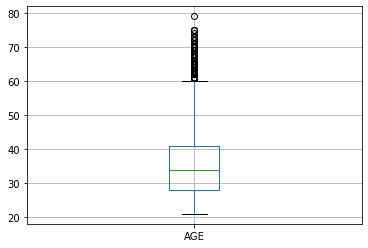

In [61]:
# boxplot for age
data.boxplot(column='AGE')

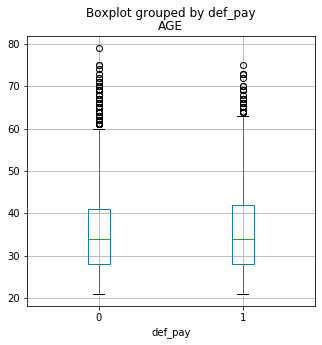

In [62]:
# boxplot for age regarding default
data.boxplot(column='AGE',by="def_pay",figsize=(5,5))

#### (2) Balance limit

In [63]:
data['LIMIT_BAL'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

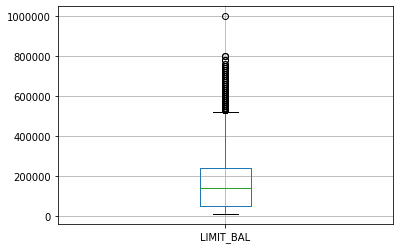

In [64]:
# boxplot for balance limit
data.boxplot(column='LIMIT_BAL')

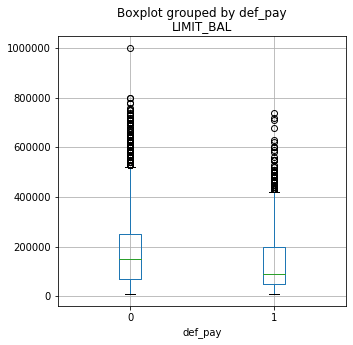

In [65]:
# boxplot for balance limit regarding default
data.boxplot(column='LIMIT_BAL',by="def_pay",figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002036F768208>]],
      dtype=object)

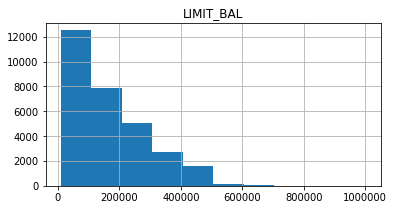

In [66]:
# histogram for balance limit
data.hist(column='LIMIT_BAL', figsize=(6, 3))

#### (3) Payment delay

In [23]:
data[repayments].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


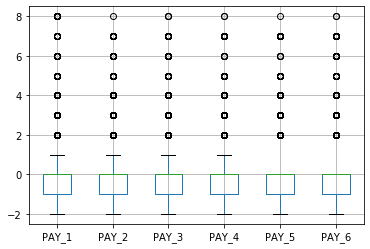

In [24]:
# boxplot for payment delay
data.boxplot(column=repayments)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1a96ac10>,
      dtype=object)

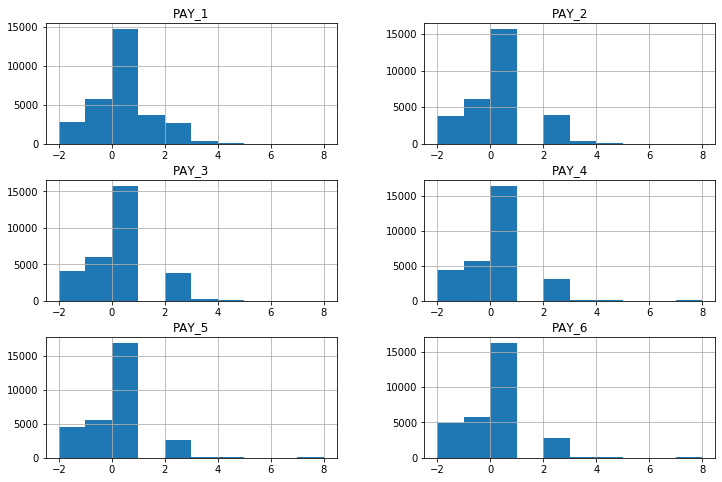

In [25]:
# histogram for payment delay
data.hist(column= repayments, figsize=(12, 8))

#### (4) Bill amounts

In [26]:
data[bill_amounts].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


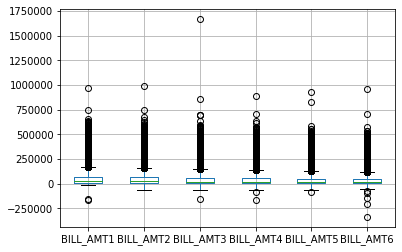

In [27]:
# boxplot for bill amounts
data.boxplot(column=bill_amounts)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b1f2850>,
      dtype=object)

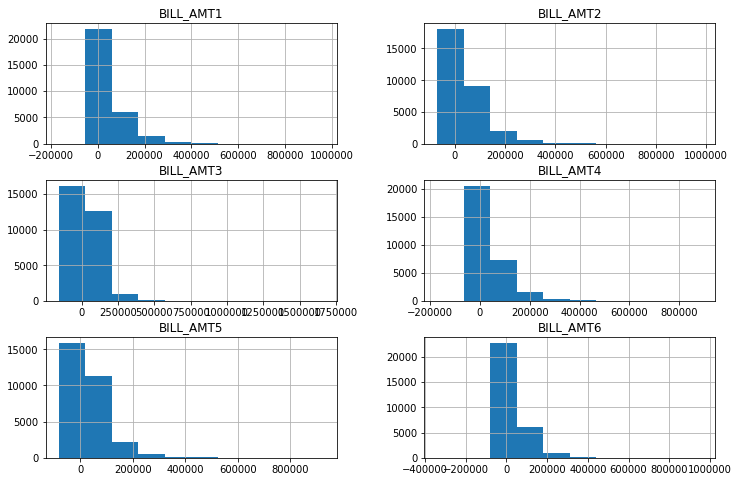

In [28]:
# histogram for bill amounts
data.hist(column= bill_amounts, figsize=(12, 8))

#### (5) Preivous payments

In [29]:
data[payments].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


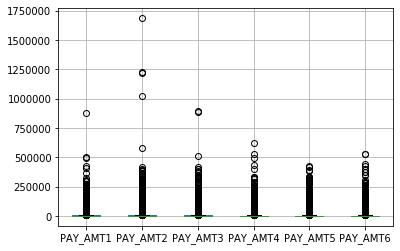

In [30]:
# boxplot for previous payments
data.boxplot(column=payments)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b8f7110>,
      dtype=object)

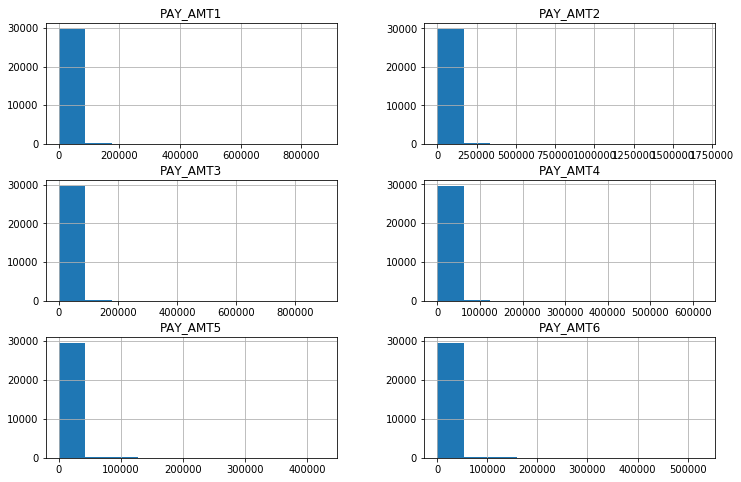

In [31]:
# histogram for preious payments
data.hist(column= payments, figsize=(12, 8))

### 2. Categorial features

In [32]:
# (old version)
# age_bins = pd.cut(data['AGE'], 10, retbins=True)
# age_bins = np.floor(age_bins).astype(int)
# df_male = data[data['SEX'] == 1]
# df_female = data[data['SEX'] == 2]

# prob_male = df_male.groupby(pd.cut(df_male['AGE'], bins=age_bins))['def_pay'].mean()
# prob_female = df_female.groupby(pd.cut(df_female['AGE'], bins=age_bins))['def_pay'].mean()

# plt.figure(figsize=(18, 6))
# plt.title('Default rate for different age groups')
# plt.bar(range(0, 30, 3), prob_male, width=1, label='Male')
# plt.bar(range(1, 31, 3), prob_female, width=1, label='Female')
# plt.xticks(range(0, 30, 3), prob_male.index)
# plt.legend(loc='upper left')
# plt.show()

#### (1) Sex

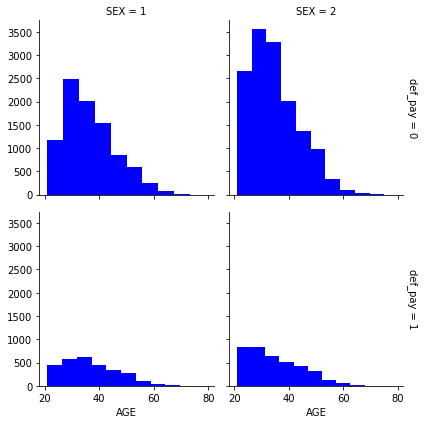

In [33]:
# Sex
# histogram for sex
g1 = sns.FacetGrid(data, col='SEX', row='def_pay', margin_titles=True)
g1.map(plt.hist,'AGE',color='blue')

<b>Conclusion: Sex is a significant feature, and we can infer that male are more likely to default than female.</b>

#### (2) Education

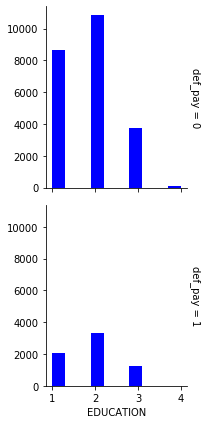

In [34]:
# Education
# histogram for education
g2 = sns.FacetGrid(data,row='def_pay', margin_titles=True)
g2.map(plt.hist,'EDUCATION',color='blue')

<b>Conclusion: Education is a significant feature, and we can infer that people with higher education level are less likely to default.</b>

#### (3) Marriage

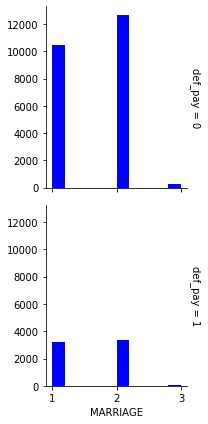

In [35]:
# MARRIAGE
# histogram for marriage
g3 = sns.FacetGrid(data,row='def_pay', margin_titles=True)
g3.map(plt.hist,'MARRIAGE',color='blue')

<b>Conclusion: Marriage is a significant feature, and we can infer that married people are more likely to default than single people.</b>

## Model Building And Evaluation

## Model 1: Decision Tree

In [325]:
# import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

### Method 1: Without feature engineering

In [411]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [412]:
# define independent variables / attirbutes / features
features = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'] + repayments + bill_amounts + payments
# define one single target variable / label
target = ['def_pay']

In [413]:
# get defined training dataset
X = data[features]
y = data[target]

In [414]:
# build a decision tree model with the defalut hyperparameter settings
DTM_0 = DecisionTreeClassifier()
DTM_0.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [415]:
DTM_0.get_depth()

44

In [416]:
DTM_0.get_n_leaves()

4747

In [417]:
# import cross validation
from sklearn.model_selection import GridSearchCV

In [418]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 5000, 500))

In [419]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [420]:
# define the model using GridSearchCV
DTM = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [421]:
DTM.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
     

In [422]:
# find the best parameters
DTM.best_params_

{'max_depth': 5, 'max_leaf_nodes': 1500}

In [423]:
DTM.best_score_

0.8196

In [424]:
DTM_best = DTM.best_estimator_

#### Model Evaluation

In [425]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [426]:
score_cv_dt = cross_val_score(DTM_best, X, y, cv=10)

In [427]:
score_cv_dt.mean()

0.8196

In [428]:
#DTM_pred = DTM_best.predict(X)
DTM_pred = cross_val_predict(DTM_best, X, y, cv=10)

In [429]:
DTM_proba = DTM_best.predict_proba(X)
#DTM_proba = cross_val_predict(DTM_best, X, y, cv=10, method='predict_proba')
DTM_proba

array([[0.51351351, 0.48648649],
       [0.56028369, 0.43971631],
       [0.90893551, 0.09106449],
       ...,
       [0.31451613, 0.68548387],
       [0.90893551, 0.09106449],
       [0.84174528, 0.15825472]])

In [430]:
cmat = confusion_matrix(y, DTM_pred)
print("Confusion Matrix:", "\n", confusion_matrix(y, DTM_pred))
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TN - True Negative {}'.format(cmat[1,1]))
print()
print("Classification Report:","\n", classification_report(y, DTM_pred,zero_division=0))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[22317  1047]
 [ 4365  2271]]
TP - True Negative 22317
FP - False Positive 1047
FN - False Negative 4365
TN - True Negative 2271

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.96      0.89     23364
           1       0.68      0.34      0.46      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.65      0.67     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8196
Misclassification Rate: 0.1804


In [431]:
fpr, tpr, thresholds = roc_curve(y, DTM_proba[:,1], pos_label=1)

In [432]:
roc_auc=auc(fpr,tpr)
roc_auc

0.763139312176536

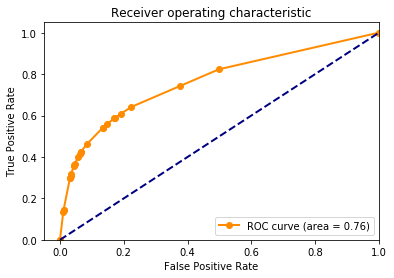

In [433]:
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Method 2: Normalize numerical features 

In [434]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [435]:
from sklearn.preprocessing import PowerTransformer
log = PowerTransformer()
log.fit(data[['LIMIT_BAL']])
data['LIMIT_BAL'] =log.transform(data[['LIMIT_BAL']])

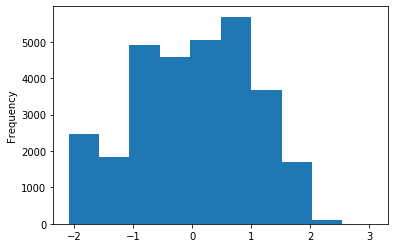

In [436]:
data['LIMIT_BAL'].plot(kind='hist')

In [437]:
for x in payments:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203053912C8>,
      dtype=object)

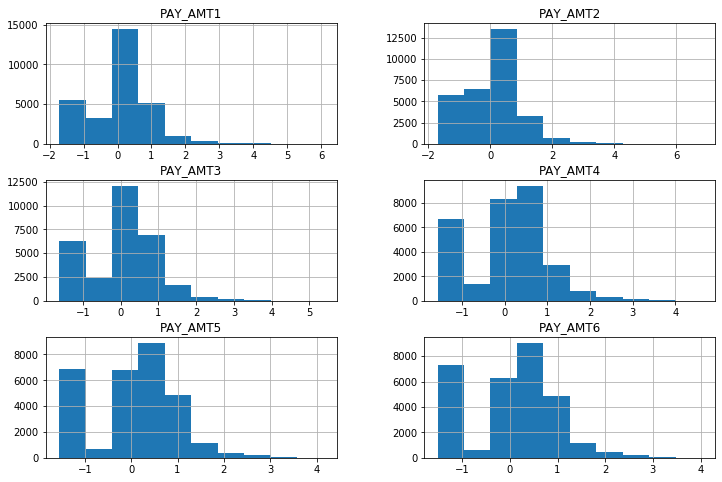

In [438]:
data.hist(column= payments, figsize=(12, 8))

In [439]:
for x in bill_amounts:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203014A0948>,
      dtype=object)

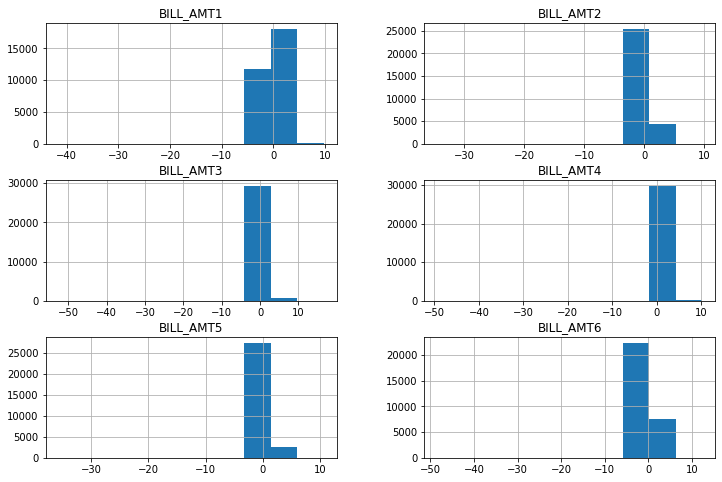

In [440]:
data.hist(column= bill_amounts, figsize=(12, 8))

#### Model building

In [441]:
features=['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'] + repayments + bill_amounts + payments
target=['def_pay']

In [442]:
X=data[features]
y=data[target]

In [443]:
DTM_0 = DecisionTreeClassifier()
DTM_0.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [444]:
DTM_0.get_depth()

44

In [445]:
DTM_0.get_n_leaves()

4755

In [446]:
from sklearn.model_selection import GridSearchCV

In [447]:
# define the numbers to try out for depth and max number of leaf nodes 
depths = list(range(5, 45, 5))
num_leafs = list(range(500, 5000, 500))

In [448]:
param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

In [449]:
DTM = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=10)

In [450]:
DTM.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
     

In [451]:
DTM.best_params_

{'max_depth': 5, 'max_leaf_nodes': 3500}

In [452]:
DTM.best_score_

0.8196333333333333

In [453]:
DTM_best = DTM.best_estimator_

#### Model evaluation

In [454]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [455]:
score_cv_dt = cross_val_score(DTM_best, X, y, cv=10)

In [456]:
score_cv_dt.mean()

0.8195666666666666

In [457]:
#DTM_pred = DTM_best.predict(X)
DTM_pred = cross_val_predict(DTM_best, X, y, cv=10)

In [458]:
DTM_proba = DTM_best.predict_proba(X)
DTM_proba

array([[0.51351351, 0.48648649],
       [0.56028369, 0.43971631],
       [0.90893551, 0.09106449],
       ...,
       [0.31451613, 0.68548387],
       [0.90893551, 0.09106449],
       [0.84174528, 0.15825472]])

In [459]:
cmat = confusion_matrix(y, DTM_pred)
print("Confusion Matrix:", "\n", confusion_matrix(y, DTM_pred))
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TN - True Negative {}'.format(cmat[1,1]))
print()
print("Classification Report:","\n", classification_report(y, DTM_pred,zero_division=0))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[22318  1046]
 [ 4365  2271]]
TP - True Negative 22318
FP - False Positive 1046
FN - False Negative 4365
TN - True Negative 2271

Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.96      0.89     23364
           1       0.68      0.34      0.46      6636

    accuracy                           0.82     30000
   macro avg       0.76      0.65      0.67     30000
weighted avg       0.80      0.82      0.80     30000

Accuracy Rate: 0.8196333333333333
Misclassification Rate: 0.18036666666666668


In [460]:
fpr, tpr, thresholds = roc_curve(y, DTM_proba[:,1], pos_label=1)

In [461]:
roc_auc=auc(fpr,tpr)
roc_auc

0.7631341329850234

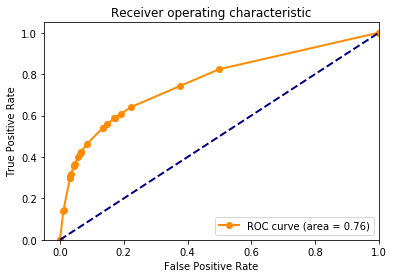

In [462]:
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Model 2 : Logistic regression

### Method 1: Normalize numerical features

In [162]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [163]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [164]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

In [165]:
numerical_features_log=['LIMIT_BAL']+payments+bill_amounts
log = PowerTransformer()
for x in numerical_features_log:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

In [166]:
numerical_features_mixmax=numerical_features_log+['AGE']+repayments
scaler = MinMaxScaler(feature_range=(-1, 1))
for x in numerical_features_mixmax:
    scaler.fit(data[[x]])
    data[x] = scaler.transform(data[[x]])

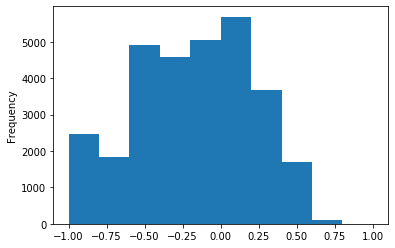

In [167]:
data['LIMIT_BAL'].plot(kind='hist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020371EBC308>,
      dtype=object)

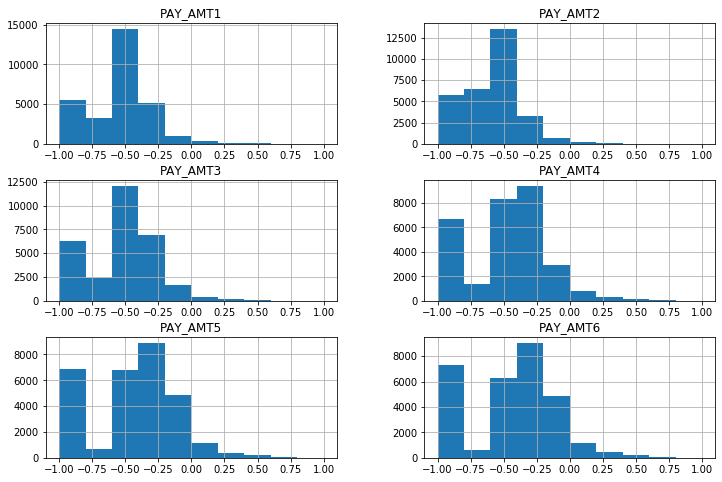

In [168]:
data.hist(column= payments, figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203726B3C08>,
      dtype=object)

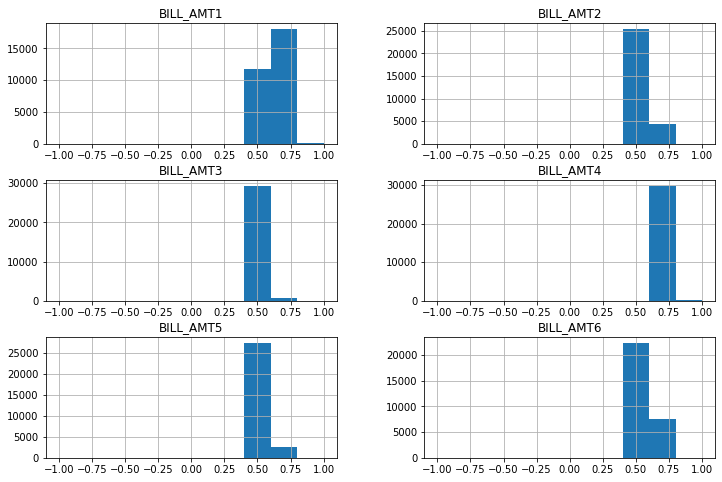

In [169]:
data.hist(column= bill_amounts, figsize=(12, 8))

#### Model building

In [170]:
X=data.drop(columns='def_pay')
y=data['def_pay']

In [171]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [172]:
lr = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)

In [173]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

#### Model Evaluation

In [174]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [175]:
# change target column to array
y_act = y.values.ravel()

In [176]:
score_cv_lr = cross_val_score(lr, X, y_act, cv=10)

In [179]:
score_cv_lr.mean()

0.8069333333333335

In [180]:
lr_pred = cross_val_predict(lr, X, y_act, cv=10)

In [182]:
lr_proba = cross_val_predict(lr, X, y_act, cv=10, method='predict_proba')
lr_proba

array([[0.40821747, 0.59178253],
       [0.78522474, 0.21477526],
       [0.82606837, 0.17393163],
       ...,
       [0.25305423, 0.74694577],
       [0.84603701, 0.15396299],
       [0.76372179, 0.23627821]])

In [183]:
cmat = confusion_matrix(y_act, lr_pred)
print("Confusion Matrix:", "\n", confusion_matrix(y_act, lr_pred))
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TN - True Negative {}'.format(cmat[1,1]))
print()
print("Classification Report:","\n", classification_report(y_act, lr_pred,zero_division=0))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[22599   765]
 [ 5027  1609]]
TP - True Negative 22599
FP - False Positive 765
FN - False Negative 5027
TN - True Negative 1609

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.97      0.89     23364
           1       0.68      0.24      0.36      6636

    accuracy                           0.81     30000
   macro avg       0.75      0.60      0.62     30000
weighted avg       0.79      0.81      0.77     30000

Accuracy Rate: 0.8069333333333333
Misclassification Rate: 0.19306666666666666


In [184]:
fpr, tpr, thresholds = roc_curve(y_act, lr_proba[:,1], pos_label=1)

In [185]:
roc_auc=auc(fpr,tpr)
roc_auc

0.7463364218084235

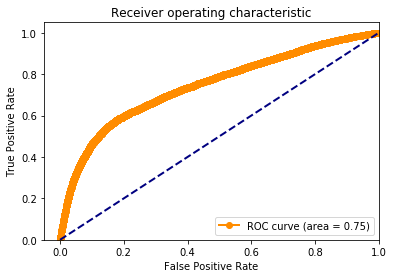

In [186]:
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Method 2: Normalize numerical features + Binning numerical features with equal intervals

In [264]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [265]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LIMIT_BAL    30000 non-null  float64
 1   AGE          30000 non-null  int64  
 2   PAY_1        30000 non-null  int64  
 3   PAY_2        30000 non-null  int64  
 4   PAY_3        30000 non-null  int64  
 5   PAY_4        30000 non-null  int64  
 6   PAY_5        30000 non-null  int64  
 7   PAY_6        30000 non-null  int64  
 8   BILL_AMT1    30000 non-null  float64
 9   BILL_AMT2    30000 non-null  float64
 10  BILL_AMT3    30000 non-null  float64
 11  BILL_AMT4    30000 non-null  float64
 12  BILL_AMT5    30000 non-null  float64
 13  BILL_AMT6    30000 non-null  float64
 14  PAY_AMT1     30000 non-null  float64
 15  PAY_AMT2     30000 non-null  float64
 16  PAY_AMT3     30000 non-null  float64
 17  PAY_AMT4     30000 non-null  float64
 18  PAY_AMT5     30000 non-null  float64
 19  PAY_

In [267]:
# normalize numerical features
from sklearn.preprocessing import PowerTransformer
numerical_features_log=['LIMIT_BAL']+payments+bill_amounts
log = PowerTransformer()
for x in numerical_features_log:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

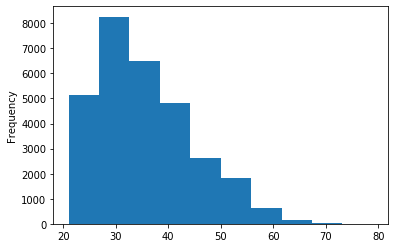

In [268]:
# age
data['AGE'].plot(kind='hist')

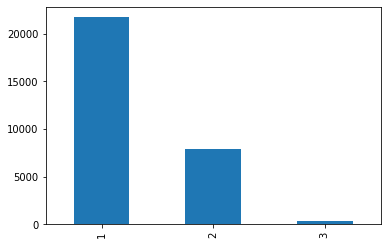

In [269]:
data['AGE_BINNED']=pd.cut(data['AGE'],3,labels=range(1,4))
data['AGE_BINNED'].value_counts().plot(kind='bar')

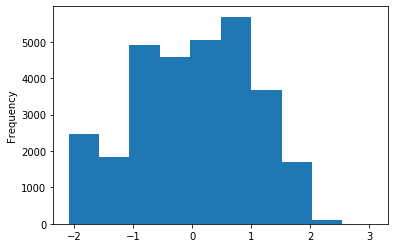

In [270]:
# limit_bal
data['LIMIT_BAL'].plot(kind='hist')

In [271]:
pd.cut(data['LIMIT_BAL'], bins=5).value_counts()

(-0.033, 1.0]       10723
(-1.066, -0.033]     9501
(1.0, 2.033]         5345
(-2.104, -1.066]     4311
(2.033, 3.066]        120
Name: LIMIT_BAL, dtype: int64

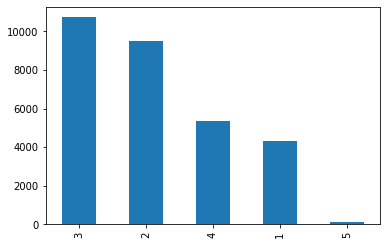

In [272]:
data['LIMIT_BAL_BINNED']=pd.cut(data['LIMIT_BAL'],5,labels=range(1,6))
data['LIMIT_BAL_BINNED'].value_counts().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020300138208>,
      dtype=object)

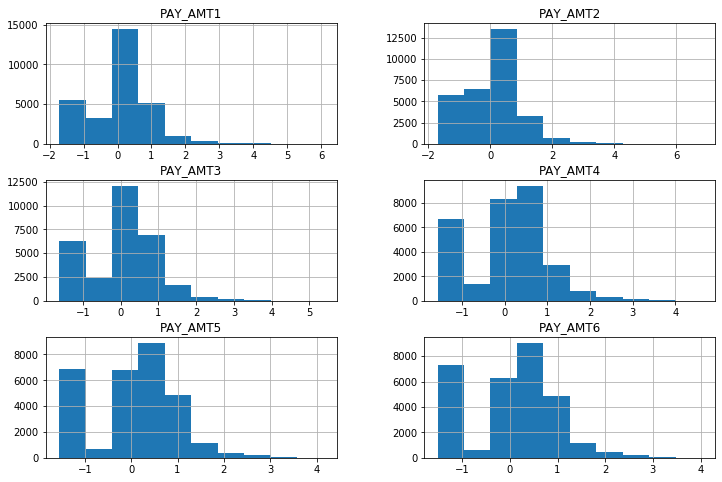

In [273]:
# payments
data.hist(column= payments, figsize=(12, 8))

In [274]:
pd.cut(data['PAY_AMT1'], bins=4).value_counts()

(-1.732, 0.226]    16852
(0.226, 2.176]     12614
(2.176, 4.127]       515
(4.127, 6.077]        19
Name: PAY_AMT1, dtype: int64

In [275]:
for x in payments:
    data[x+'_BINNED']=pd.cut(data[x],4,labels=range(1,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002030012B288>,
      dtype=object)

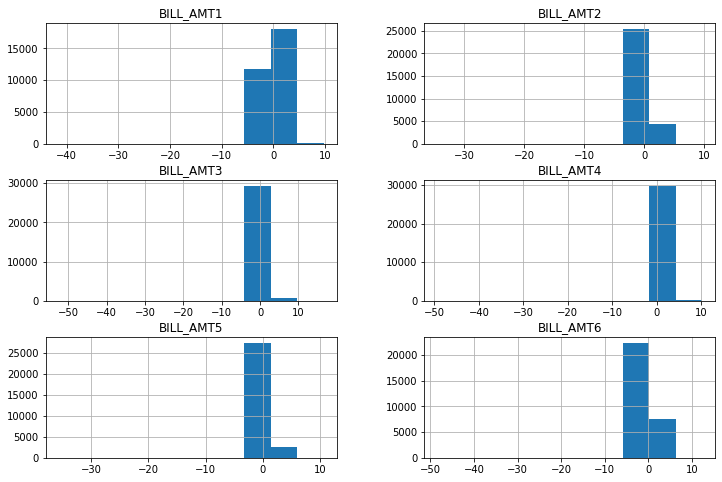

In [276]:
# bill_amounts
data.hist(column= bill_amounts, figsize=(12, 8))

In [277]:
pd.cut(data['BILL_AMT1'], bins=4).value_counts()

(-3.061, 9.749]       29996
(-15.871, -3.061]         2
(-41.542, -28.681]        2
(-28.681, -15.871]        0
Name: BILL_AMT1, dtype: int64

In [278]:
for x in bill_amounts:
    data[x+'_BINNED']=pd.cut(data[x],4,labels=range(1,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203007B5208>,
      dtype=object)

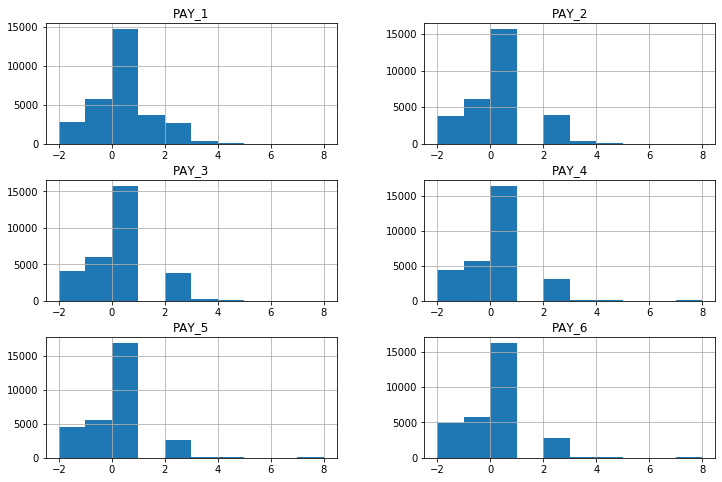

In [279]:
# repayments
data.hist(column= repayments, figsize=(12, 8))

In [284]:
pd.cut(data['PAY_1'], bins=5).value_counts()

(-2.01, 0.0]    23182
(0.0, 2.0]       6355
(2.0, 4.0]        398
(4.0, 6.0]         37
(6.0, 8.0]         28
Name: PAY_1, dtype: int64

In [285]:
for x in repayments:
    data[x+'_BINNED']=pd.cut(data[x],4,labels=range(1,5))

In [286]:
# import LabelEncoder
from sklearn import preprocessing
# create LabelEncoder
le = preprocessing.LabelEncoder()

In [287]:
# label encoding
numerical_features_binned=['AGE_BINNED','LIMIT_BAL_BINNED','PAY_AMT1_BINNED','PAY_AMT2_BINNED','PAY_AMT3_BINNED','PAY_AMT4_BINNED',
                           'PAY_AMT5_BINNED','PAY_AMT6_BINNED','BILL_AMT1_BINNED','BILL_AMT2_BINNED','BILL_AMT3_BINNED','BILL_AMT4_BINNED',
                           'BILL_AMT5_BINNED','BILL_AMT6_BINNED','PAY_1_BINNED','PAY_2_BINNED','PAY_3_BINNED','PAY_4_BINNED',
                           'PAY_5_BINNED','PAY_6_BINNED']
for x in numerical_features_binned:
    data[x] = le.fit_transform(data[x])

#### Model building

In [262]:
#features=['SEX','MARRIAGE','EDUCATION'] + numerical_features_binned
#target=['def_pay']

In [290]:
columns_to_drop=['def_pay','AGE','LIMIT_BAL'] +payments +repayments +bill_amounts
X=data.drop(columns=columns_to_drop)
y=data['def_pay']

In [291]:
# import Logistic Regression from sklearn
from sklearn.linear_model import LogisticRegression

In [292]:
lr = LogisticRegression(penalty='l1', solver='saga',max_iter=1000)

In [293]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

#### Model Evaluation

In [294]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc
import matplotlib as mpl
import matplotlib.pyplot as plt

In [295]:
# change target column to array
y_act = y.values.ravel()

In [296]:
score_cv_lr = cross_val_score(lr, X, y_act, cv=10)

In [297]:
score_cv_lr.mean()

0.8051333333333334

In [298]:
lr_pred = cross_val_predict(lr, X, y_act, cv=10)

In [299]:
lr_proba = cross_val_predict(lr, X, y_act, cv=10, method='predict_proba')
lr_proba

array([[0.45910614, 0.54089386],
       [0.75075828, 0.24924172],
       [0.86470383, 0.13529617],
       ...,
       [0.22253803, 0.77746197],
       [0.65255778, 0.34744222],
       [0.82045772, 0.17954228]])

In [300]:
cmat = confusion_matrix(y_act, lr_pred)
print("Confusion Matrix:", "\n", confusion_matrix(y_act, lr_pred))
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TN - True Negative {}'.format(cmat[1,1]))
print()
print("Classification Report:","\n", classification_report(y_act, lr_pred,zero_division=0))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

Confusion Matrix: 
 [[22327  1037]
 [ 4809  1827]]
TP - True Negative 22327
FP - False Positive 1037
FN - False Negative 4809
TN - True Negative 1827

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.96      0.88     23364
           1       0.64      0.28      0.38      6636

    accuracy                           0.81     30000
   macro avg       0.73      0.62      0.63     30000
weighted avg       0.78      0.81      0.77     30000

Accuracy Rate: 0.8051333333333334
Misclassification Rate: 0.19486666666666666


In [301]:
fpr, tpr, thresholds = roc_curve(y_act, lr_proba[:,1], pos_label=1)

In [302]:
roc_auc=auc(fpr,tpr)
roc_auc

0.7592784957956058

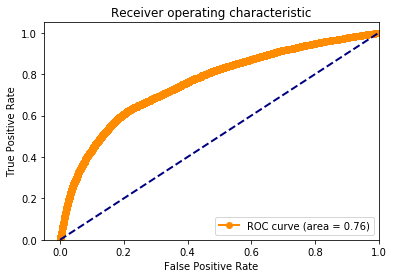

In [303]:
%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Model 3: K-means clustering

In [304]:
data = pd.read_csv('data/data_clean.csv',index_col = 'ID')

In [305]:
# the categorical features to carry out feature engineering
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

In [306]:
# one-hot encoding
data = pd.get_dummies(data, columns=categorical_features,drop_first = True)

In [307]:
# numerical features
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

In [308]:
numerical_features_log=['LIMIT_BAL']+payments+bill_amounts
log = PowerTransformer()
for x in numerical_features_log:
    log.fit(data[[x]])
    data[x] =log.transform(data[[x]])

In [309]:
numerical_features_mixmax=numerical_features_log+['AGE']+repayments
scaler = MinMaxScaler(feature_range=(-1, 1))
for x in numerical_features_mixmax:
    scaler.fit(data[[x]])
    data[x] = scaler.transform(data[[x]])

#### Model building

In [310]:
X = data.drop(columns='def_pay')
y = data['def_pay']

In [311]:
# import KMeans from sklearn
from sklearn.cluster import KMeans

In [312]:
# set number of clusters
kmeansmodel = KMeans(n_clusters=2)

In [313]:
# fit data
kmeansmodel.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [314]:
# centroids
centroids = kmeansmodel.cluster_centers_
centroids

array([[-1.32764571e-01, -4.77186685e-01, -6.24209461e-01,
        -6.54034910e-01, -6.58967873e-01, -6.68176069e-01,
        -6.75094865e-01, -6.78952694e-01,  6.18002458e-01,
         5.60539089e-01,  5.19044422e-01,  6.56993608e-01,
         5.38027603e-01,  5.91772963e-01, -5.56794568e-01,
        -5.99857619e-01, -5.35323562e-01, -4.94147909e-01,
        -4.56607561e-01, -4.54272726e-01,  5.91639261e-01,
        -7.77156117e-14,  3.14571212e-01,  7.90538831e-03,
         5.62484189e-01,  1.01821401e-02],
       [-2.47896016e-01, -5.26481825e-01, -5.80081759e-01,
        -5.96349027e-01, -6.04567240e-01, -6.17338596e-01,
        -6.28883564e-01, -6.35114181e-01,  6.21117918e-01,
         5.64245143e-01,  5.21060294e-01,  6.59235704e-01,
         5.40482732e-01,  5.93750384e-01, -5.59209261e-01,
        -6.00904602e-01, -5.34286127e-01, -4.88590887e-01,
        -4.52986920e-01, -4.53180567e-01,  6.17211728e-01,
         1.00000000e+00, -2.02060590e-14, -1.41553436e-15,
         5.00

In [315]:
# centroids
iteration = kmeansmodel.n_iter_
iteration

16

In [316]:
# SSD
SSD = kmeansmodel.inertia_
SSD

52490.88815105222

In [317]:
# centroids
distance = kmeansmodel.transform(X)
distance

array([[2.03736737, 1.6736444 ],
       [1.60638585, 1.1823995 ],
       [1.26622621, 0.69416356],
       ...,
       [1.99684211, 1.63423713],
       [1.58038223, 1.99130482],
       [1.4441091 , 0.93918327]])

In [318]:
# Get Labels of each point 
data_label = kmeansmodel.labels_

In [319]:
# Create comparison table between actual def_pay and predict cluster
data_comparison=pd.DataFrame(data_label,y,columns=['cluster'])
data_comparison

,cluster
def_pay,
1,1
1,1
0,1
0,1
0,1
...,...
0,0
0,0
1,1


In [320]:
# Find corresponding instances that belong to each def_pay type
data_nondefault = data_comparison.loc[0]
data_default = data_comparison.loc[1]

In [321]:
# Count value for different cluster regarding one type of def_pay
data_nondefault[data_nondefault.columns[0]].value_counts()

0    12516
1    10848
Name: cluster, dtype: int64

In [322]:
data_default[data_default.columns[0]].value_counts()

1    3340
0    3296
Name: cluster, dtype: int64

Based on majority rule, cluster 0 is default, cluster 1 is nondefault.

#### Model Evaluation

In this case, the cardinality is fixed due to that the number of clusters is fixed, so the way of checking if cardinality correlates with magnitude cannot be used. Thus, the only way is to interpret the above results, which kind of serve as a "confusion matrix".

In [323]:
kmeans_TN=data_nondefault.loc[data_nondefault.cluster == 1, 'cluster'].count()
kmeans_TP=data_default.loc[data_default.cluster == 0, 'cluster'].count()
kmeans_FN=data_default.loc[data_default.cluster == 1, 'cluster'].count()
kmeans_FP=data_nondefault.loc[data_nondefault.cluster == 0, 'cluster'].count()

In [324]:
kmeans_accuracy=(kmeans_TN+kmeans_TP)/(kmeans_TN+kmeans_TP+kmeans_FN+kmeans_FP)
kmeans_accuracy

0.47146666666666665

Accuracy is around 0.5, which is similar to random guess.